# Preprocess
This notebook is responsible for preprocessing the images. Run this notebook if you want to train the models.

## Contents:
**0. Configuration**
- Configuring paths
- Unzipping the GP22 dataset
- Verifying paths

**1. Preprocessing** (will be performed on the images and labels inside the `./model_training` folder)
- Crop (Remove background noise)
- Flip (Every car should be in the same direction)
- Scale (Scale all cars according to a reference car)
- Augmentation (Data augmentation on the images)
- Execute (Run the scripts)

**2. Visualization**
- Here you can visualize the preprocessing steps and verify their integrity

**3. Splitting**
- The dataset will be split into train, test, and validation sets
- Also includes visualization of the final dataset

What will you need to do?
- Create a dir named *data* in the root folder of the project
- Download the GP22 Dataset (https://zenodo.org/records/6366808), both Images.zip and Labels.zip
- Put Images.zip and Labels.zip in the data folder
- Run code block below to generate directories

## 0. Configuration

### 0.1 Path

NOTE: These preprocessing steps are performed on the images contained in the model_training folder (can be found on [Teams](https://chalmers.sharepoint.com/:f:/s/StudentTRA235/EucRJsbp-FVHtJNnHZEIZhIB0xyTaJHSPOQlXy4_4Zfp0g?e=JjSBZN)). These paths refer to previously annotated data, including images and their associated JSON labels.
If you want to add more data, you can manually annotate new images using LabelMe and place both the images and their corresponding JSON labels into the following folders: data/model_training/images and data/model_training/json_labels

In [3]:
# configure paths here 
path_to_orientation_model = "../checkpoints/orientation_classifier_checkpoint.pth"
path_to_gp22_images = "../data/GP22/images"
path_to_gp22_labels = "../data/GP22/labels"
path_images_for_training = "../data/model_training/images"
path_to_txt_labels_for_training = "../data/model_training/labels_txt"
path_to_json_labels_for_training = "../data/model_training/json_labels"


output_dir_images_cropped = "../data/processed/cropped/images"
output_dir_labels_cropped = "../data/processed/cropped/labels"
output_dir_images_flipped = "../data/processed/flipped/images"
output_dir_labels_txt_flipped = "../data/processed/flipped/txt_labels"
output_dir_labels_json_flipped = "../data/processed/flipped/json_labels"
output_dir_scaled = "../data/processed/scaled"
output_dir_images_scaled = "../data/processed/scaled/images"
output_augmentations_dir = "../data/processed/augmentations"

### 0.2 Import libraries

In [4]:
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torchvision import transforms, models
from PIL import Image
from pathlib import Path
import shutil
import json
import pandas as pd
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

### 0.3 Directories generation

In [3]:

def ensure_directories_exist(paths):
    """ 
    Ensure that the directories in the given paths exist. If they do not, create them.
    Args:
        paths (list): List of paths to directories to ensure exist.
    Returns:
        None
    """

    for path in paths:
        directory = path if path.endswith('/') or '.' not in os.path.basename(path) else os.path.dirname(path)
        if not os.path.exists(directory):
            os.makedirs(directory)
            print(f"Created directory: {directory}")
        else:
            print(f"Directory already exists: {directory}")

In [4]:
# Configure paths here
paths = [
    "../data",
    "../data/GP22/images",
    "../data/GP22/labels",
    "../data/model_training/images",
    "../data/model_training/json_labels",
    "../data/model_training/labels_txt",
    "../data/processed/cropped/images",
    "../data/processed/cropped/labels",
    "../data/processed/flipped/images",
    "../data/processed/flipped/txt_labels",
    "../data/processed/flipped/json_labels",
    "../data/processed/scaled",
    "../data/processed/augmentations/images",
    "../data/processed/augmentations/masks",
]


In [5]:
ensure_directories_exist(paths)

Directory already exists: ../data
Created directory: ../data/GP22/images
Created directory: ../data/GP22/labels
Directory already exists: ../data/model_training/images
Directory already exists: ../data/model_training/json_labels
Directory already exists: ../data/model_training/labels_txt
Created directory: ../data/processed/cropped/images
Created directory: ../data/processed/cropped/labels
Created directory: ../data/processed/flipped/images
Created directory: ../data/processed/flipped/txt_labels
Created directory: ../data/processed/flipped/json_labels
Created directory: ../data/processed/scaled
Created directory: ../data/processed/augmentations/images
Created directory: ../data/processed/augmentations/masks


### 0.4 Unzip of GP22 dataset

In [6]:
# Define paths
base_dir = "../data/GP22"
images_zip = "../data/Images.zip"
labels_zip = "../data/Labels.zip"
images_dir = os.path.join(base_dir, "images")
labels_dir = os.path.join(base_dir, "labels")

# Function to remove __MACOSX folder if it exists
def remove_macosx_folder(base_dir):
    macosx_path = os.path.join(base_dir, "__MACOSX")
    if os.path.exists(macosx_path):
        shutil.rmtree(macosx_path)
        print(f"Removed {macosx_path}.")

# Check and unzip Images.zip
if os.path.exists(images_zip):
    if not os.listdir(images_dir):
        print(f"Extracting {images_zip} to {images_dir}...")
        with zipfile.ZipFile(images_zip, 'r') as zip_ref:
            zip_ref.extractall(base_dir) 
        print(f"Extraction complete: {images_dir}")
        os.remove(images_zip)
        print(f"Deleted {images_zip}.")
        remove_macosx_folder(base_dir)
    else:
        print(f"{images_dir} already contains files. Skipping extraction of {images_zip}.")
else:
    print(f"{images_zip} not found.")

# Check and unzip Labels.zip
if os.path.exists(labels_zip):
    if not os.listdir(labels_dir):
        print(f"Extracting {labels_zip} to {labels_dir}...")
        with zipfile.ZipFile(labels_zip, 'r') as zip_ref:
            zip_ref.extractall(base_dir)
        print(f"Extraction complete: {labels_dir}")
        os.remove(labels_zip)
        print(f"Deleted {labels_zip}.")
        remove_macosx_folder(base_dir)
    else:
        print(f"{labels_dir} already contains files. Skipping extraction of {labels_zip}.")
else:
    print(f"{labels_zip} not found.")


Extracting ../data/Images.zip to ../data/GP22\images...
Extraction complete: ../data/GP22\images
Deleted ../data/Images.zip.
Removed ../data/GP22\__MACOSX.
Extracting ../data/Labels.zip to ../data/GP22\labels...
Extraction complete: ../data/GP22\labels
Deleted ../data/Labels.zip.
Removed ../data/GP22\__MACOSX.


In [7]:
# Check if each image has a corresponding label
def check_images_labels(images_path, labels_path):
    images = os.listdir(images_path)
    labels = os.listdir(labels_path)
    images = {
        os.path.splitext(f)[0]
        for f in os.listdir(images_path)
        if f.endswith(".jpg") and not f.startswith(".")
    }
    labels = {
        os.path.splitext(f)[0]
        for f in os.listdir(labels_path)
        # if f.endswith(".json") and not f.startswith(".") # for json labels
        if f.endswith(".txt") and not f.startswith(".") # for txt labels
    }
    if set(images) == set(labels):
        print("All images have corresponding labels")
    else:
        print("Some images don't have corresponding labels")
        print("Images without labels: ", set(images) - set(labels))
        print("Labels without images: ", set(labels) - set(images))

# Change the paths
check_images_labels(path_to_gp22_images, path_to_gp22_labels)

All images have corresponding labels


# 1. Preprocessing

## 1.1 Crop
Removing background noise improves model performance.
The following code block will: 
- Use GP22 labels to process the images and remove background

In [8]:
def crop_out_background(images_dir, labels_dir, output_images_dir, output_labels_dir):
    """
    Process all images in a directory, crop out the background using bounding boxes, 
    and save updated labels to a new directory.

    Args:
        images_dir (str): Path to the directory containing the images.
        labels_dir (str): Path to the directory containing the labels.
        output_images_dir (str): Path to the directory to save the cropped images.
        output_labels_dir (str): Path to the directory to save the updated labels.

    Returns:
        None
    """
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)

    for image_path in Path(images_dir).glob("*.jpg"):
        label_path = Path(labels_dir) / f"{image_path.stem}.txt"

        if not label_path.exists():
            print(f"No label found for {image_path.name}. Skipping.")
            continue

        image = cv2.imread(str(image_path))
        if image is None:
            print(f"Could not read the image at {image_path}. Skipping.")
            continue

        img_height, img_width = image.shape[:2]

        mask = np.zeros(image.shape[:2], dtype=np.uint8)

        bounding_boxes = []
        updated_labels = []
        with open(label_path, 'r') as file:
            for line in file:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                bounding_boxes.append([x_center, y_center, width, height])

        for (x_center, y_center, width, height) in bounding_boxes:
            x = int((x_center - width / 2) * img_width)
            y = int((y_center - height / 2) * img_height)
            w = int(width * img_width)
            h = int(height * img_height)

            # Draw bounding box on the mask
            cv2.rectangle(mask, (x, y), (x + w, y + h), 255, thickness=-1)

            # Update labels with pixel coordinates
            new_x_center = (x + w / 2) / img_width
            new_y_center = (y + h / 2) / img_height
            new_width = w / img_width
            new_height = h / img_height
            updated_labels.append(f"{int(class_id)} {new_x_center:.6f} {new_y_center:.6f} {new_width:.6f} {new_height:.6f}")

        # Apply the mask to the image
        result = cv2.bitwise_and(image, image, mask=mask)

        # Save the cropped image
        output_image_path = Path(output_images_dir) / image_path.name
        cv2.imwrite(str(output_image_path), result)

        # Save the updated labels
        output_label_path = Path(output_labels_dir) / f"{image_path.stem}.txt"
        with open(output_label_path, 'w') as file:
            file.write("\n".join(updated_labels))

        print(f"Processed and saved: {image_path.name}")

## 1.2 Flip
Every car should be pointing in the same direction.
The following code blocks will:
- Load the orientation model
- Predict whether a car is pointing left or right
- Flip the corresponding label of each car
- Flip the image of the car itself

We have chosen to flip cars to the **left**. That is, nose points to the left.

### 1.2.1 Load the orientation model

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_orientation_model(checkpoint_path):
    """
    Loads the trained orientation model from the given checkpoint path.
    Args:
        checkpoint_path (str): Path to the checkpoint file.
    Returns:
        torch.nn.Module: The loaded model.
    """
    model = models.resnet18(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    print(f"Model loaded from {checkpoint_path}")
    return model

### 1.2.2 Predict orientation

In [10]:
def predict_orientation(model, image_path):
    """
    Predicts the orientation of the car in the image.
    Args:
        model (torch.nn.Module): The orientation model.
        image_path (str): Path to the image.
    Returns:
        str: The predicted orientation ("left" or "right").
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        return "left" if predicted.item() == 0 else "right"

### 1.2.3 Flip x-coordinates of txt labels

In [11]:
def flip_labels_txt_x(label_path, output_label_dir):
    """
    Flips the x-coordinates of labels and saves them to a new directory.

    Args:
        label_path (str): Path to the label file.
        output_label_dir (str): Path to the directory to save the flipped labels.
    Returns:
        None
    """
    os.makedirs(output_label_dir, exist_ok=True)

    flipped_labels = []
    with open(label_path, 'r') as f:
        for line in f:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            x_center = 1 - x_center  # Flip the x-coordinate
            flipped_labels.append(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    output_label_path = os.path.join(output_label_dir, os.path.basename(label_path))
    with open(output_label_path, 'w') as f:
        f.write("\n".join(flipped_labels))
    
    print(f"Flipped labels saved to {output_label_path}")

### 1.2.4 Flip x-coordinates of json labels

In [12]:
def flip_labels_json_x(label_path, output_label_dir, w):
    """
    Flips the x-coordinates of labels in a JSON format and saves them.
    """
    os.makedirs(output_label_dir, exist_ok=True)
    label_path = Path(label_path)
    if label_path.exists():
        with open(label_path, "r") as f:
            label_data = json.load(f)
            # Flip label points horizontally
            for shape in label_data["shapes"]:
                for point in shape["points"]:
                    point[0] = w - point[0]  # Adjust x-coordinate for flipping

        # Save updated label
        output_label_path = Path(output_label_dir) / label_path.name
        with open(output_label_path, "w") as f:
            json.dump(label_data, f, indent=4)

### 1.2.5 Flip images

In [13]:
def flip_image(image_path, output_image_dir):
    """
    Flips an image horizontally and saves it to the output directory.

    Args:
        image_path (str): Path to the image.
        output_image_dir (str): Path to the directory to save the flipped image.
    Returns:
        str: Path to the saved flipped image.
    """
    os.makedirs(output_image_dir, exist_ok=True)

    image = cv2.imread(str(image_path))
    h, w = image.shape[:2]  # Get image dimensions

    flipped_image = cv2.flip(image, 1)
    output_image_path = os.path.join(output_image_dir, os.path.basename(image_path))
    cv2.imwrite(output_image_path, flipped_image)
    
    print(f"Flipped image saved to {output_image_path}")
    return output_image_path, w

### 1.2.6 Flip Images and Labels
Run this to process all images and labels

In [14]:
def flip_images_and_labels(model, images_dir, labels_txt_dir, labels_json_dir, output_image_dir, output_txt_label_dir, output_json_label_dir):
    """
    Flips images and labels horizontally based on the predicted orientation.

    Args:
        model (torch.nn.Module): The orientation model.
        images_dir (str): Path to the directory containing the images.
        labels_txt_dir (str): Path to the directory containing the txt labels.
        labels_json_dir (str): Path to the directory containing the json labels.
        output_image_dir (str): Path to the directory to save the flipped images.
        output_txt_label_dir (str): Path to the directory to save the flipped txt labels.
        output_json_label_dir (str): Path to the directory to save the flipped json labels.
    """
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_txt_label_dir, exist_ok=True)
    os.makedirs(output_json_label_dir, exist_ok=True)


    for image_path in Path(images_dir).glob("*.jpg"):
        label_txt_path = Path(labels_txt_dir) / f"{image_path.stem}.txt"
        label_json_path = Path(labels_json_dir) / f"{image_path.stem}.json"
        
        if label_txt_path.exists() and label_json_path.exists():
            orientation = predict_orientation(model, str(image_path))
            flipped = False

            if orientation == "right":
                flipped = True
                _, w = flip_image(str(image_path), output_image_dir)
                flip_labels_txt_x(str(label_txt_path), output_txt_label_dir)
                flip_labels_json_x(str(label_json_path), output_json_label_dir, w)
            else:
                shutil.copy(str(image_path), os.path.join(output_image_dir, image_path.name))
                shutil.copy(str(label_txt_path), os.path.join(output_txt_label_dir, label_txt_path.name))
                shutil.copy(str(label_json_path), os.path.join(output_json_label_dir, label_json_path.name))
                print(f"Image and labels copied to {output_image_dir} and {output_txt_label_dir}" and {output_json_label_dir})
        else:
            print(f"Label file not found for {image_path}")


## 1.3 Scale
Cars should be relative to each other in size.
The following code blocks will:
- Calculate rim area (used as a reference when scaling)
- Calculate scaling factor (based on reference car and current car)
- Scale images and update labels

### 1.3.1 Rim area

In [6]:
def calculate_rim_area_of_front_wheel(label_path, resolution=1024):
    """
    Returns {area} of front-wheel rim
    Important! Car nose should be pointing left

    Args:
        label_path (str): Path to the label file.
        resolution (int): Resolution of the image.
    Returns:
        float: Area of the front-wheel rim in the image.
    """
    smallest_x = float("inf")
    smallest_box = None

    with open(label_path, "r") as file:
        for line in file:
            class_id, x_center, y_center, width, height = line.strip().split()
            if int(class_id) == 1: 
                x_center = float(x_center)
                if x_center < smallest_x:
                    smallest_x = x_center
                    smallest_box = (float(width), float(height))

    if smallest_box:
        width, height = smallest_box
        area = width * height * (resolution**2)
        return area
    else:
        return 0

### 1.3.2 Scaling factor

In [7]:
def compare_area(rim_area_reference_car, rim_area_current_car):
    """
    Calculate the scaling factor to adjust the dimensions of the current car
    so that its area matches the area of the reference car.

    Args:
        rim_area_reference_car (float): Area of the front-wheel rim of the reference car.
        rim_area_current_car (float): Area of the front-wheel rim of the current car.
    Returns:
        float: Scaling factor to adjust the dimensions of the current car.
    """
    if rim_area_reference_car <= 0 or rim_area_current_car <= 0:
        raise ValueError("Both areas must be positive numbers.")
    
    scaling_factor = (rim_area_reference_car / rim_area_current_car) ** 0.5
    
    return scaling_factor

### 1.3.3 Scale JSON labels

In [8]:
import base64
def update_json_labels(json_path, scaling_factor, offset_x, offset_y, labels_dir, padded_image_path):
    """
    Updates the JSON labels to match the scaled and padded image and updates the base64 string.

    Args:
        json_path (str): Path to the JSON label file.
        scaling_factor (float): Scaling factor to adjust the dimensions of the current car.
        offset_x (int): The x-offset to center the points.
        offset_y (int): The y-offset to center the points.
        labels_dir (str): Path to the directory to save the updated JSON labels.
        padded_image_path (str): Path to the scaled and padded image.
    Returns:
        None
    """
    with open(json_path, 'r') as file:
        data = json.load(file)

    # Scale and offset points
    for shape in data['shapes']:
        new_points = []
        for point in shape['points']:
            # First scale the points
            scaled_x = point[0] * scaling_factor
            scaled_y = point[1] * scaling_factor
            
            # Then add the positive offset to center the points
            scaled_x += offset_x
            scaled_y += offset_y

            # Only include points that fall within the 1024x1024 canvas
            if 0 <= scaled_x < 1024 and 0 <= scaled_y < 1024:
                new_points.append([scaled_x, scaled_y])

        shape['points'] = new_points

    # Update image metadata
    data['imageWidth'] = 1024
    data['imageHeight'] = 1024

    # Update the base64 string
    with open(padded_image_path, 'rb') as img_file:
        img_data = img_file.read()
        encoded_data = base64.b64encode(img_data).decode('utf-8')
        data['imageData'] = encoded_data

    # Save updated JSON
    json_filename = os.path.basename(json_path)
    updated_json_path = os.path.join(labels_dir, json_filename)

    with open(updated_json_path, 'w') as file:
        json.dump(data, file, indent=4)

    print(f"Updated JSON labels and base64 for {json_filename}.")


### 1.3.4 Scale images


In [9]:
def scale_and_crop_image(image_path, scaling_factor, label_path, json_label_path, output_dir):
    """
    Scales an image by a given scaling factor, ensures it is padded to 1024x1024 pixels,
    and scales corresponding JSON labels.

    Args:
        image_path (str): Path to the image.
        scaling_factor (float): Scaling factor to adjust the dimensions of the current car.
        label_path (str): Path to the label file.
        json_label_path (str): Path to the JSON label file.
        output_dir (str): Path to the directory to save the scaled image.
    Returns:
        None
    """
    if scaling_factor <= 0:
        raise ValueError("Scaling factor must be a positive number.")

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image file not found: {image_path}")

    # Get original dimensions
    original_height, original_width = image.shape[:2]

    # Compute new dimensions
    new_width = int(original_width * scaling_factor)
    new_height = int(original_height * scaling_factor)

    # Resize the image using OpenCV
    scaled_image = cv2.resize(
        image, (new_width, new_height), interpolation=cv2.INTER_LINEAR
    )

    # Ensure the image is 1024x1024 by padding with black if necessary
    target_size = 1024
    padded_image = np.zeros((target_size, target_size, 3), dtype=np.uint8)

    # Center the scaled image in the 1024x1024 canvas
    offset_x = (target_size - new_width) // 2 if new_width < target_size else 0
    offset_y = (target_size - new_height) // 2 if new_height < target_size else 0

    insert_width = min(new_width, target_size)
    insert_height = min(new_height, target_size)

    padded_image[offset_y:offset_y+insert_height, offset_x:offset_x+insert_width] = \
        scaled_image[:insert_height, :insert_width]

    # Create directories for images and labels
    images_dir = os.path.join(output_dir, "images")
    labels_dir = os.path.join(output_dir, "labels")
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    # Save padded image
    image_filename = os.path.basename(image_path)
    padded_image_path = os.path.join(images_dir, image_filename)
    cv2.imwrite(padded_image_path, padded_image)

    # Update JSON labels
    update_json_labels(json_label_path, scaling_factor, offset_x, offset_y, labels_dir, padded_image_path)

## 1.4 Augmentation

In [19]:
import albumentations as A

c:\Users\mikae\Desktop\tratest\.venv\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.1' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [20]:
def augment_dataset(images_dir, masks_dir, output_dir, num_augmented=2):
    """
    Augments an entire dataset of images and corresponding masks for segmentation tasks.

    Parameters:
        images_dir (str): Directory containing input images.
        masks_dir (str): Directory containing input masks.
        output_dir (str): Directory to save augmented images and masks.
        num_augmented (int): Number of augmented copies to generate for each image-mask pair.
    """
    transform = A.Compose(
        [
            A.RandomBrightnessContrast(p=0.2),  # Adjust brightness and contrast of the image.
            A.GaussianBlur(blur_limit=(3, 5), p=0.2),  # Adds slight blurring.
            A.HueSaturationValue(
                hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3
            ),  # Changes hue, saturation, and value.
            A.Resize(1024, 1024, always_apply=True),  # Ensures image and mask are resized consistently.
        ]
    )

    # Create output directories
    output_images_dir = Path(output_dir) / "images"
    output_masks_dir = Path(output_dir) / "masks"
    output_images_dir.mkdir(parents=True, exist_ok=True)
    output_masks_dir.mkdir(parents=True, exist_ok=True)

    # Process all images and masks
    for image_path in Path(images_dir).glob("*.jpg"):
        mask_path = Path(masks_dir) / f"{image_path.stem}.png"
        if not mask_path.exists():
            print(f"Mask for {image_path.name} not found. Skipping.")
            continue

        # Load image and mask
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        for i in range(num_augmented):
            # Apply augmentation
            transformed = transform(image=image, mask=mask)
            aug_image = transformed["image"]
            aug_mask = transformed["mask"]

            # Save augmented image and mask
            aug_image_name = f"{image_path.stem}_aug_{i}.jpg"
            aug_mask_name = f"{mask_path.stem}_aug_{i}.png"
            cv2.imwrite(
                str(output_images_dir / aug_image_name),
                cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR),
            )
            cv2.imwrite(str(output_masks_dir / aug_mask_name), aug_mask)

    print(f"Augmented dataset saved in {output_dir}")

## 1.5 Execute
The following code blocks will execute corresponding code for:
- Removing background
- Flipping images and labels
- Scaling images and labels

### 1.5.1 Crop

In [21]:
path_images_for_training          # Directory with GP22 images
path_to_txt_labels_for_training          # Directory with bounding box labels (text files)
output_dir_images_cropped    # Directory to save cropped images
output_dir_labels_cropped    # Directory to save cropped labels

crop_out_background(path_images_for_training, path_to_txt_labels_for_training, output_dir_images_cropped, output_dir_labels_cropped)

Processed and saved: A_Ast_01.jpg
Processed and saved: A_Cit_01.jpg
Processed and saved: A_Fia_01.jpg
Processed and saved: A_Fia_02.jpg
Processed and saved: A_Fia_03.jpg
Processed and saved: A_Fia_04.jpg
Processed and saved: A_Fia_05.jpg
Processed and saved: A_Fia_06.jpg
Processed and saved: A_Hyu_02.jpg
Processed and saved: A_Hyu_03.jpg
Processed and saved: A_Hyu_04.jpg
Processed and saved: A_Hyu_05.jpg
Processed and saved: A_Hyu_06.jpg
Processed and saved: A_Hyu_07.jpg
Processed and saved: A_Hyu_08.jpg
Processed and saved: A_Hyu_09.jpg
Processed and saved: A_Hyu_10.jpg
Processed and saved: A_Hyu_11.jpg
Processed and saved: A_Hyu_12.jpg
Processed and saved: A_Ope_01.jpg
Processed and saved: A_Ope_02.jpg
Processed and saved: A_Ope_03.jpg
Processed and saved: A_Ope_04.jpg
Processed and saved: A_Ope_05.jpg
Processed and saved: A_Ope_06.jpg
Processed and saved: A_Ope_07.jpg
Processed and saved: A_Peu_01.jpg
Processed and saved: A_Peu_02.jpg
Processed and saved: A_Peu_03.jpg
Processed and 

### 1.5.2 Flip

In [22]:
path_to_orientation_model   # Directory with orientation model
output_dir_images_cropped   # Directory with cropped images
path_to_json_labels_for_training         # Directory with JSON labels
output_dir_images_flipped   # Directory to save flipped images
output_dir_labels_txt_flipped  # Directory to save flipped labels txt
output_dir_labels_json_flipped  # Directory to save flipped labels json

model = load_orientation_model(path_to_orientation_model)

flip_images_and_labels(
    model, 
    output_dir_images_cropped,
    output_dir_labels_cropped,
    path_to_json_labels_for_training, 
    output_dir_images_flipped, 
    output_dir_labels_txt_flipped,
    output_dir_labels_json_flipped
)

c:\Users\mikae\Desktop\tratest\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mikae\Desktop\tratest\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\mikae\AppData\Local\Temp\ipykernel_26124\3320539876.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `wei

Model loaded from ../checkpoints/orientation_classifier_checkpoint.pth
Flipped image saved to ../data/processed/flipped/images\A_Ast_01.jpg
Flipped labels saved to ../data/processed/flipped/txt_labels\A_Ast_01.txt
{'../data/processed/flipped/json_labels'}
Flipped image saved to ../data/processed/flipped/images\A_Fia_01.jpg
Flipped labels saved to ../data/processed/flipped/txt_labels\A_Fia_01.txt
Flipped image saved to ../data/processed/flipped/images\A_Fia_02.jpg
Flipped labels saved to ../data/processed/flipped/txt_labels\A_Fia_02.txt
{'../data/processed/flipped/json_labels'}
{'../data/processed/flipped/json_labels'}
Flipped image saved to ../data/processed/flipped/images\A_Fia_05.jpg
Flipped labels saved to ../data/processed/flipped/txt_labels\A_Fia_05.txt
Flipped image saved to ../data/processed/flipped/images\A_Fia_06.jpg
Flipped labels saved to ../data/processed/flipped/txt_labels\A_Fia_06.txt
{'../data/processed/flipped/json_labels'}
{'../data/processed/flipped/json_labels'}
Flip

### 1.5.3 Scale

In [10]:
def scale_all_images_and_labels(reference_label_path, images_folder, labels_folder, json_labels_folder, output_folder, resolution=1024):
    """
    Scales images and corresponding labels
    """
    # Create output directories
    images_output_dir = os.path.join(output_folder, "images")
    labels_output_dir = os.path.join(output_folder, "labels")
    os.makedirs(images_output_dir, exist_ok=True)
    os.makedirs(labels_output_dir, exist_ok=True)

    # Ensure the reference label path is valid
    if not os.path.exists(reference_label_path):
        print(f"Reference label path {reference_label_path} does not exist.")
        return
    
    reference_area = calculate_rim_area_of_front_wheel(reference_label_path, resolution)
    print(f"Reference area: {reference_area}")
    
    # Loop through label files in the label folder
    print(f"Looking for label files in: {labels_folder}")
    for label_file in os.listdir(labels_folder):
        if label_file.endswith(".txt"):
            print(f"Found label file: {label_file}")
            label_path = os.path.join(labels_folder, label_file)
            
            current_area = calculate_rim_area_of_front_wheel(label_path, resolution)
            print(f"Current area for {label_file}: {current_area}")
            
            # Get corresponding image file
            image_name = label_file.replace(".txt", ".jpg")  # Assuming images are .jpg
            image_path = Path(images_folder) / image_name  # Use Path to handle path joining
            image_path = str(image_path).replace("\\", "/")
            print(f"Looking for image: {image_path}")
            
            if not os.path.exists(image_path):
                print(f"Image {image_name} corresponding to label {label_file} does not exist. Skipping.")
                continue

            # Get corresponding JSON label file (assumes the JSON label has the same name as the .txt label)
            json_label_name = label_file.replace(".txt", ".json")
            json_label_path = os.path.join(json_labels_folder, json_label_name)
            print(f"Looking for JSON label: {json_label_path}")
            
            if not os.path.exists(json_label_path):
                print(f"JSON label {json_label_name} for {label_file} does not exist. Skipping.")
                continue

            print(f"Processing: {image_name} and {label_file}")

            scaling_factor = compare_area(reference_area, current_area)
            print(f"Scaling factor for {label_file}: {scaling_factor}")

            # Process the image and label
            try:
                scale_and_crop_image(image_path, scaling_factor, label_path, json_label_path, output_folder)
                print(f"Processed and saved: {image_name} and {label_file}")
            except Exception as e:
                print(f"Error processing {image_name} and {label_file}: {e}")


path_to_reference_car_label = "../data/GP22/labels/B_Ren_12.txt" # Directory to chosen reference car
output_dir_images_flipped   # Directory to images of flipped cars
output_dir_labels_json_flipped   # Directory to labels of flipped cars in json format
output_dir_scaled           # Directory to save images and labels of scaled cars

scale_all_images_and_labels(
    path_to_reference_car_label, 
    output_dir_images_flipped, 
    path_to_gp22_labels, 
    output_dir_labels_json_flipped, 
    output_dir_scaled
)

Reference area: 5852.002969599345
Looking for label files in: ../data/GP22/labels
Found label file: A_Ast_01.txt
Current area for A_Ast_01.txt: 18360.0
Looking for image: ../data/processed/flipped/images/A_Ast_01.jpg
Looking for JSON label: ../data/processed/flipped/json_labels\A_Ast_01.json
Processing: A_Ast_01.jpg and A_Ast_01.txt
Scaling factor for A_Ast_01.txt: 0.5645675736217495
Updated JSON labels and base64 for A_Ast_01.json.
Processed and saved: A_Ast_01.jpg and A_Ast_01.txt
Found label file: A_Cit_01.txt
Current area for A_Cit_01.txt: 19042.964800012287
Looking for image: ../data/processed/flipped/images/A_Cit_01.jpg
Looking for JSON label: ../data/processed/flipped/json_labels\A_Cit_01.json
Processing: A_Cit_01.jpg and A_Cit_01.txt
Scaling factor for A_Cit_01.txt: 0.5543511931310803
Updated JSON labels and base64 for A_Cit_01.json.
Processed and saved: A_Cit_01.jpg and A_Cit_01.txt
Found label file: A_Fia_01.txt
Current area for A_Fia_01.txt: 9701.998719999672
Looking for ima

### 1.5.4 Augmentation execution

In [24]:
import os
import json
import cv2
import numpy as np
from pathlib import Path

def create_masks(labelme_dir, output_mask_dir):
    """
    Converts LabelMe JSON annotations to binary masks.

    Parameters:
        labelme_dir (str): Directory containing LabelMe JSON files.
        output_mask_dir (str): Directory to save generated masks.
    """
    # Ensure the output directory exists
    os.makedirs(output_mask_dir, exist_ok=True)

    # Clear any existing .jpg masks in the output directory
    for mask_file in Path(output_mask_dir).glob("*.jpg"):
        os.remove(mask_file)

    for json_file in Path(labelme_dir).glob("*.json"):
        with open(json_file, "r") as f:
            label_data = json.load(f)

        # Get image dimensions
        img_height = label_data["imageHeight"]
        img_width = label_data["imageWidth"]

        # Create an empty mask
        mask = np.zeros((img_height, img_width), dtype=np.uint8)

        # Add polygons to the mask
        for shape in label_data["shapes"]:
            if shape["label"] == "window":  # Use only "window" labels
                points = np.array(shape["points"], dtype=np.int32)
                cv2.fillPoly(mask, [points], color=1)

        # Save the mask as .png
        mask_name = Path(label_data["imagePath"]).stem + ".png"
        mask_path = os.path.join(output_mask_dir, mask_name)
        cv2.imwrite(mask_path, mask * 255)  # Convert to 0-255 scale for saving as PNG

    print(f"Masks saved in {output_mask_dir}")


In [25]:
# Need to delete A_Hyu_01.jpg
create_masks("../data/processed/scaled/labels", "../data/processed/scaled/masks")
output_scaled_mask_dir = "../data/processed/scaled/masks" 
augment_dataset(output_dir_images_scaled, output_scaled_mask_dir, output_augmentations_dir, num_augmented=2)

Masks saved in ../data/processed/scaled/masks


C:\Users\mikae\AppData\Local\Temp\ipykernel_26124\3066579575.py:18: UserWarning: Argument 'always_apply' is not valid and will be ignored.
  A.Resize(1024, 1024, always_apply=True),  # Ensures image and mask are resized consistently.


Augmented dataset saved in ../data/processed/augmentations


## 2. Visualization

In [26]:
def draw_bounding_box(image_path, bounding_boxes):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    img_height, img_width = image.shape[:2]

    # Define the colors
    colors = {
        0: (255, 0, 0),
        1: (0, 255, 0),
        2: (0, 0, 255),
        3: (255, 255, 0),
        4: (255, 0, 255),
        5: (0, 255, 255),
    }

    for bbox in bounding_boxes:
        class_id, x_center, y_center, width, height = bbox

        # Convert the coordinates to absolute values
        x_center, y_center = int(x_center * img_width), int(y_center * img_height)
        width, height = int(width * img_width), int(height * img_height)

        # Calculate the top-left and bottom-right corner of the bounding box
        x1 = int(x_center - width / 2)
        y1 = int(y_center - height / 2)
        x2 = int(x_center + width / 2)
        y2 = int(y_center + height / 2)

        # Class color
        color = colors[class_id]

        # Draw the bounding box
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        # Add the class name
        cv2.putText(
            image, str(class_id), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2
        )

    # Display the image
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [27]:
def visualize_mask(image_path, mask_path):
    """
    Visualizes the original image and its corresponding mask.

    Parameters:
        image_path (str): Path to the input image.
        mask_path (str): Path to the binary mask.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Segmentation Mask")
    plt.axis("off")

    plt.show()

### 2.1 Original

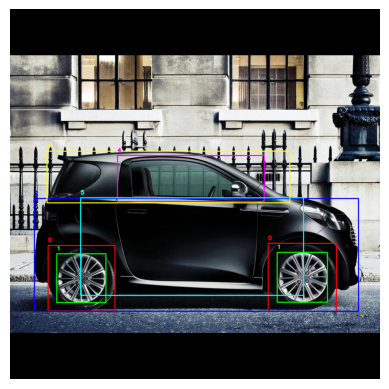

In [28]:
image_path = '../data/model_training/images/A_Ast_01.jpg'
image_label_path = '../data/model_training/labels_txt/A_Ast_01.txt'

bounding_boxes = []
with open(image_label_path, 'r') as file:
    for line in file:
        class_id, x_center, y_center, width, height = line.strip().split()
        bounding_boxes.append([int(class_id), float(x_center), float(y_center), float(width), float(height)])

draw_bounding_box(image_path, bounding_boxes)

In [29]:
json_labels_dir = "../data/model_training/json_labels"  # Directory containing LabelMe JSON files
output_mask_dir = "../data/model_training/masks"  # Directory of masks

# Create masks from JSON labels
create_masks(json_labels_dir, output_mask_dir)

Masks saved in ../data/model_training/masks


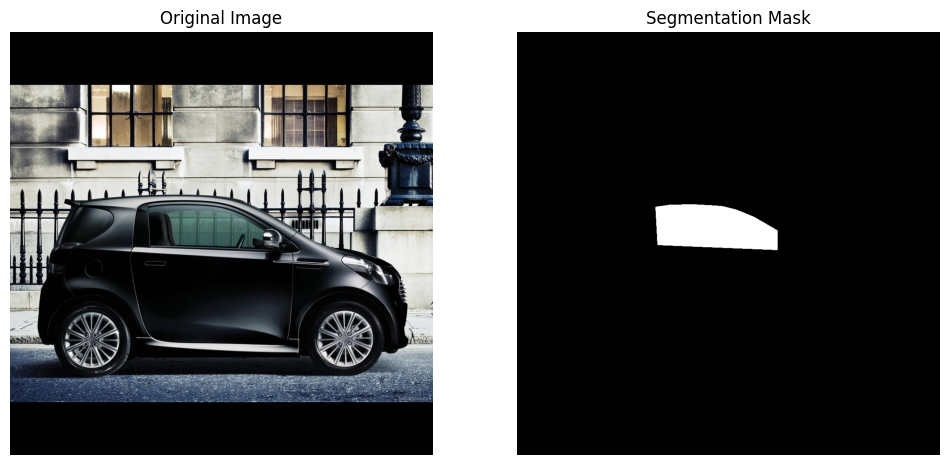

In [30]:
# Change the paths to visualize a different mask
visualize_mask("../data/model_training/images/A_Ast_01.jpg", "../data/model_training/masks/A_Ast_01.png")

### 2.2 Cropped

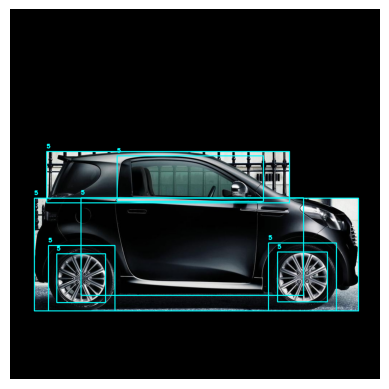

In [31]:
image_path = '../data/processed/cropped/images/A_Ast_01.jpg'
image_label_path = '../data/processed/cropped/labels/A_Ast_01.txt'

bounding_boxes = []
with open(image_label_path, 'r') as file:
    for line in file:
        class_id, x_center, y_center, width, height = line.strip().split()
        bounding_boxes.append([int(class_id), float(x_center), float(y_center), float(width), float(height)])

draw_bounding_box(image_path, bounding_boxes)

### 2.3 Flipped

In [32]:
json_flipped_labels_dir = "../data/processed/flipped/json_labels" 
output_scaled_mask_dir = "../data/processed/flipped/masks"  

# Create masks from JSON labels
create_masks(json_flipped_labels_dir, output_scaled_mask_dir)

Masks saved in ../data/processed/flipped/masks


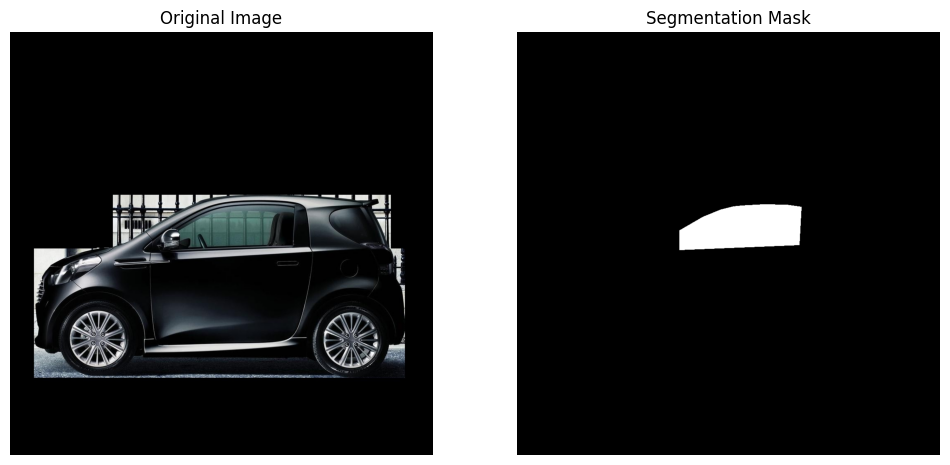

In [33]:
# Change the paths to visualize a different mask
visualize_mask("../data/processed/flipped/images/A_Ast_01.jpg", "../data/processed/flipped/masks/A_Ast_01.png")

In [34]:
def visualize_augmented_data(image_dir, mask_dir, num_samples=5):
    """
    Visualizes a few augmented image-mask pairs.

    Parameters:
        image_dir (str): Directory containing augmented images.
        mask_dir (str): Directory containing augmented masks.
        num_samples (int): Number of samples to visualize.
    """
    image_paths = sorted(Path(image_dir).glob("*.jpg"))[:num_samples]
    mask_paths = sorted(Path(mask_dir).glob("*.png"))[:num_samples]

    for img_path, mask_path in zip(image_paths, mask_paths):
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"Augmented Image: {img_path.name}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="gray")
        plt.title(f"Augmented Mask: {mask_path.name}")
        plt.axis("off")

        plt.show()

### 2.4 Augmentation visualization

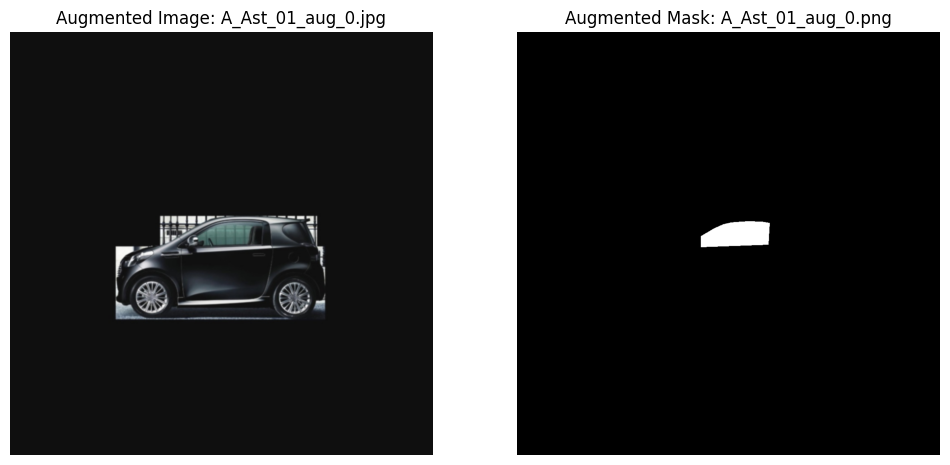

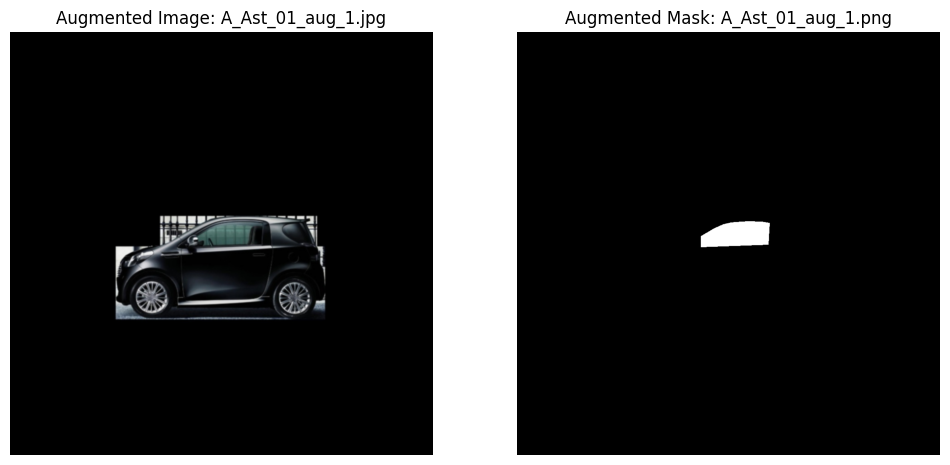

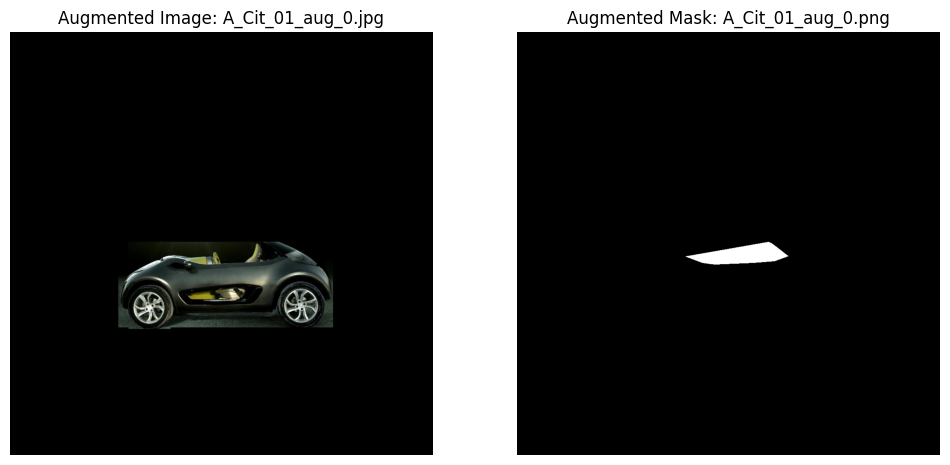

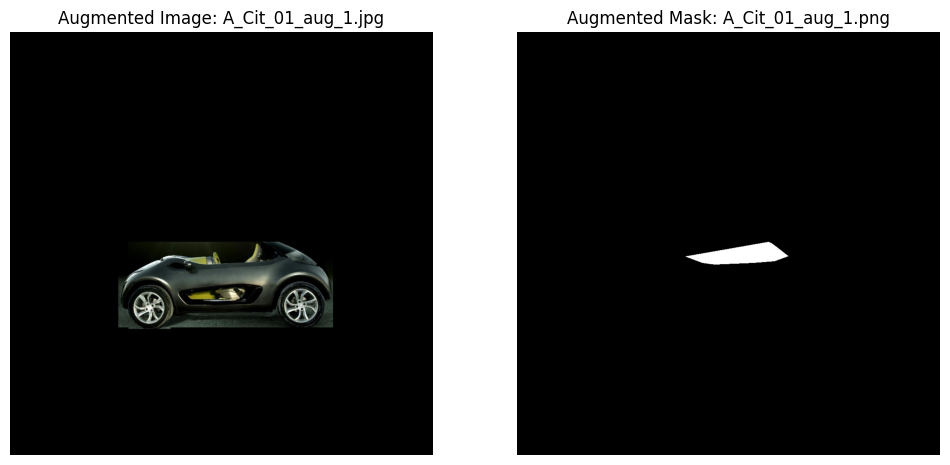

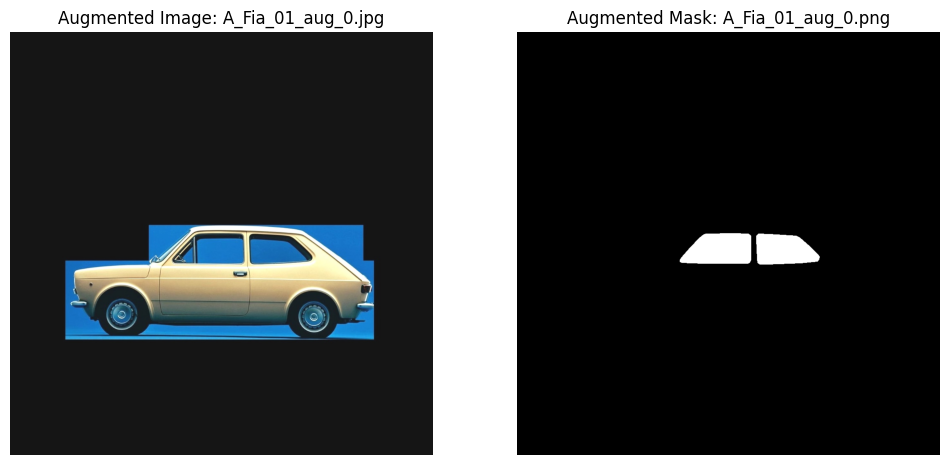

In [35]:
augmented_images_dir = "../data/processed/augmentations/images"
augmented_masks_dir = "../data/processed/augmentations/masks"
visualize_augmented_data(augmented_images_dir, augmented_masks_dir)

## 3. Dataset Splitting 

In [36]:
from sklearn.model_selection import train_test_split

augmented_images_dir = "../data/processed/augmentations/images"
augmented_masks_dir = "../data/processed/augmentations/masks"
output_split_dir = "../data/model_training/split"

In [37]:
def split_dataset(images_dir, masks_dir, output_dir, train_ratio=0.7, val_ratio=0.2):
    """
    Splits the augmented dataset into train, val, and test sets.

    Parameters:
        images_dir (str): Directory containing augmented images.
        masks_dir (str): Directory containing augmented masks.
        output_dir (str): Base directory for the split datasets.
        train_ratio (float): Proportion of data for training (default: 0.7).
        val_ratio (float): Proportion of data for validation (default: 0.2).
    """
    # Get all images and masks
    images = sorted(Path(images_dir).glob("*.jpg"))
    masks = sorted(Path(masks_dir).glob("*.png"))

    # Ensure images and masks match
    assert len(images) == len(masks), "Number of images and masks do not match!"
    for img, mask in zip(images, masks):
        assert img.stem == mask.stem, f"Mismatch: {img.stem} and {mask.stem}"

    # Split dataset into train, val, and test
    train_images, temp_images, train_masks, temp_masks = train_test_split(
        images, masks, test_size=(1 - train_ratio), random_state=42
    )
    val_ratio_adjusted = val_ratio / (1 - train_ratio)  # Adjust for remaining data
    val_images, test_images, val_masks, test_masks = train_test_split(
        temp_images, temp_masks, test_size=(1 - val_ratio_adjusted), random_state=42
    )

    # Define output directories
    splits = {"train": (train_images, train_masks), 
              "val": (val_images, val_masks), 
              "test": (test_images, test_masks)}

    for split, (split_images, split_masks) in splits.items():
        split_image_dir = Path(output_dir) / split / "images"
        split_mask_dir = Path(output_dir) / split / "masks"
        split_image_dir.mkdir(parents=True, exist_ok=True)
        split_mask_dir.mkdir(parents=True, exist_ok=True)

        # Move files to respective directories
        for img, mask in zip(split_images, split_masks):
            shutil.copy(img, split_image_dir / img.name)
            shutil.copy(mask, split_mask_dir / mask.name)

    print(f"Dataset split into train, val, and test sets in {output_dir}")

### 3.1 Split execution


In [38]:
split_dataset(augmented_images_dir, augmented_masks_dir, output_split_dir)

Dataset split into train, val, and test sets in ../data/model_training/split


In [39]:
def visualize_split(split_dir, num_samples=1):
    images_dir = Path(split_dir) / "images"
    masks_dir = Path(split_dir) / "masks"

    image_paths = sorted(images_dir.glob("*.jpg"))[:num_samples]
    mask_paths = sorted(masks_dir.glob("*.png"))[:num_samples]

    for img_path, mask_path in zip(image_paths, mask_paths):
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"Image: {img_path.name}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="gray")
        plt.title(f"Mask: {mask_path.name}")
        plt.axis("off")

        plt.show()

In [40]:
def get_num_images(images_path):
    return len(
        [
            f
            for f in os.listdir(images_path)
            if f.endswith(".jpg") and not f.startswith(".")
        ]
    )

### 3.3 Split visualization

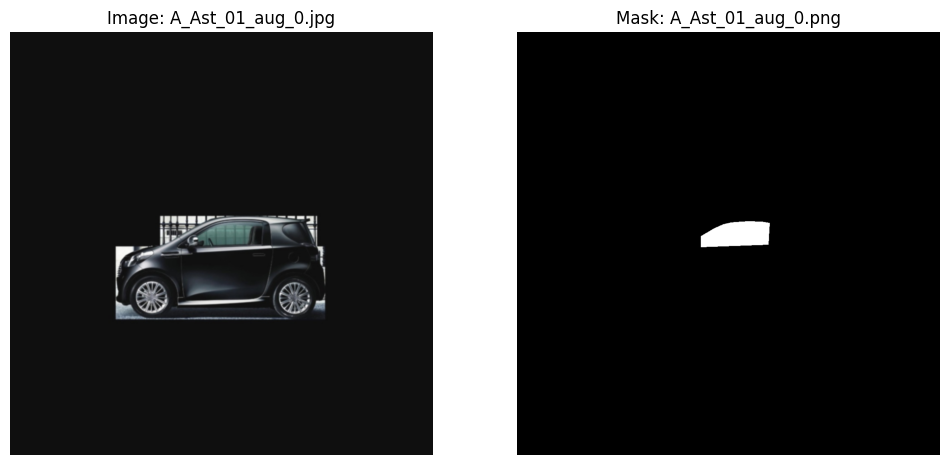

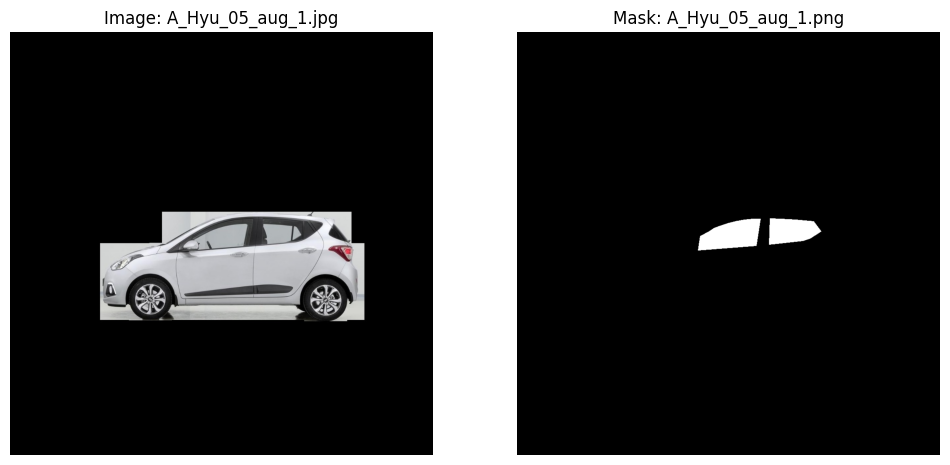

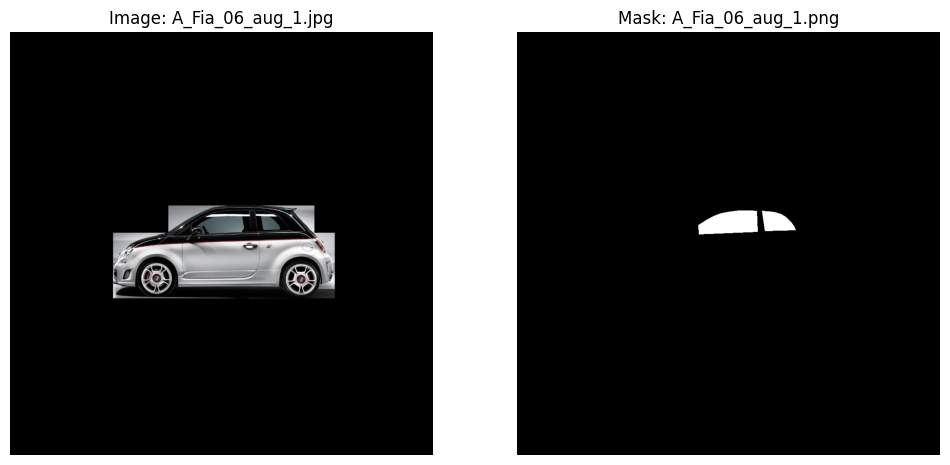

Number of training images: 1118
Number of validation images: 319
Number of testing images: 161


In [41]:
visualize_split("../data/model_training/split/train")
visualize_split("../data/model_training/split/val")
visualize_split("../data/model_training/split/test")

train_images = get_num_images(images_path="../data/model_training/split/train/images")
val_images = get_num_images(images_path="../data/model_training/split/val/images")
test_images = get_num_images(images_path="../data/model_training/split/test/images")

print(f"Number of training images: {train_images}")
print(f"Number of validation images: {val_images}")
print(f"Number of testing images: {test_images}")